In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from foottraffic import FoottrafficModel
import pymc as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az


# Start by Loading a Dataset 
This is just a folder that contains the mff with the file name data.csv and a metadata json file
Running the following command 
```python
FoottrafficModel.new_from_dataset("path/to/data", output='model_name')
```
will create a template for you to use to build your model

In [3]:
FoottrafficModel.new_from_dataset('complex_model/data', output="example_model")

/Users/mreda/miniconda3/envs/foottraffic/lib/python3.11/site-packages/pydantic/main.py:352: UserWarning: Pydantic serializer warnings:
  Expected `tuple[literal['Geography','Period','Product','Outlet','Campaign','Creative'], ...]` but got `list` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_json(


You should now have a folder called **example_model** in your local directory. Your data and metadata now lives in the **data** subdirectory. You also should see a file called **model_def.json**. This is where the model can be defined currently there is a placeholder that must be edited for the model to run.

**See the README for more detail**

For now, lets open up a model that was already setup it's in a folder called **complex_model**.
Take a look at the **model_def.json** file. 

***Hint** if you are using vscode you can right click in the file and select format document in the drop down to make the file more human readable*

You will see I have 3 variables defined in the variable details list. One control variable Promotions_Total_Total_Total, one media variable media_var_0_Total_Total_Total, and one exog variable Stock_Total_Total_Total.

Media variables are special they receive media transforms such as deminishing return curves and adstock.
Exog variables define the likelihood for the model and are similar to the dependent variables in an AWB model.
Control variables can be used to define other independant variables that are in the model.


Let's load up the model now!

In [4]:
my_model = FoottrafficModel.load('complex_model')

## Now we just fit the model

In [5]:
my_model.fit() # We can change the sampler settings by passing arguments to fit
#e.g. my_model.fit(draws=2000, tune=1000, chains=4, overwrite=True) to run 4 chains 
# of 2000 draws each with 1000 tuning steps and allow the model to overwrite the existing results
# this may take a while go grab a coffee

['Geography', 'Product', 'Period']
['Geography', 'Product', 'Period']


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept_fixed_coeff, media_var_0_Total_Total_Total_fixed_coeff, media_var_0_Total_Total_Total_K_, media_var_0_Total_Total_Total_n_, Promotion_Total_Total_Total_fixed_coeff, Promotion_Total_Total_Total_rand_coeff_sigma, Promotion_Total_Total_Total_rand_coeff]


/Users/mreda/miniconda3/envs/foottraffic/lib/python3.11/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 140 seconds.


## Assuming that went well let's checkout how our model did

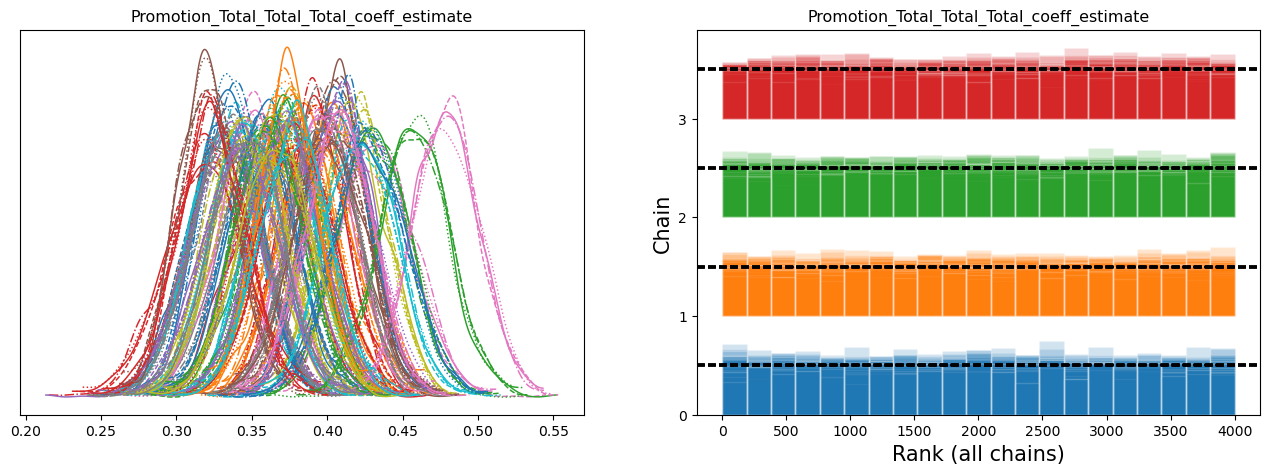

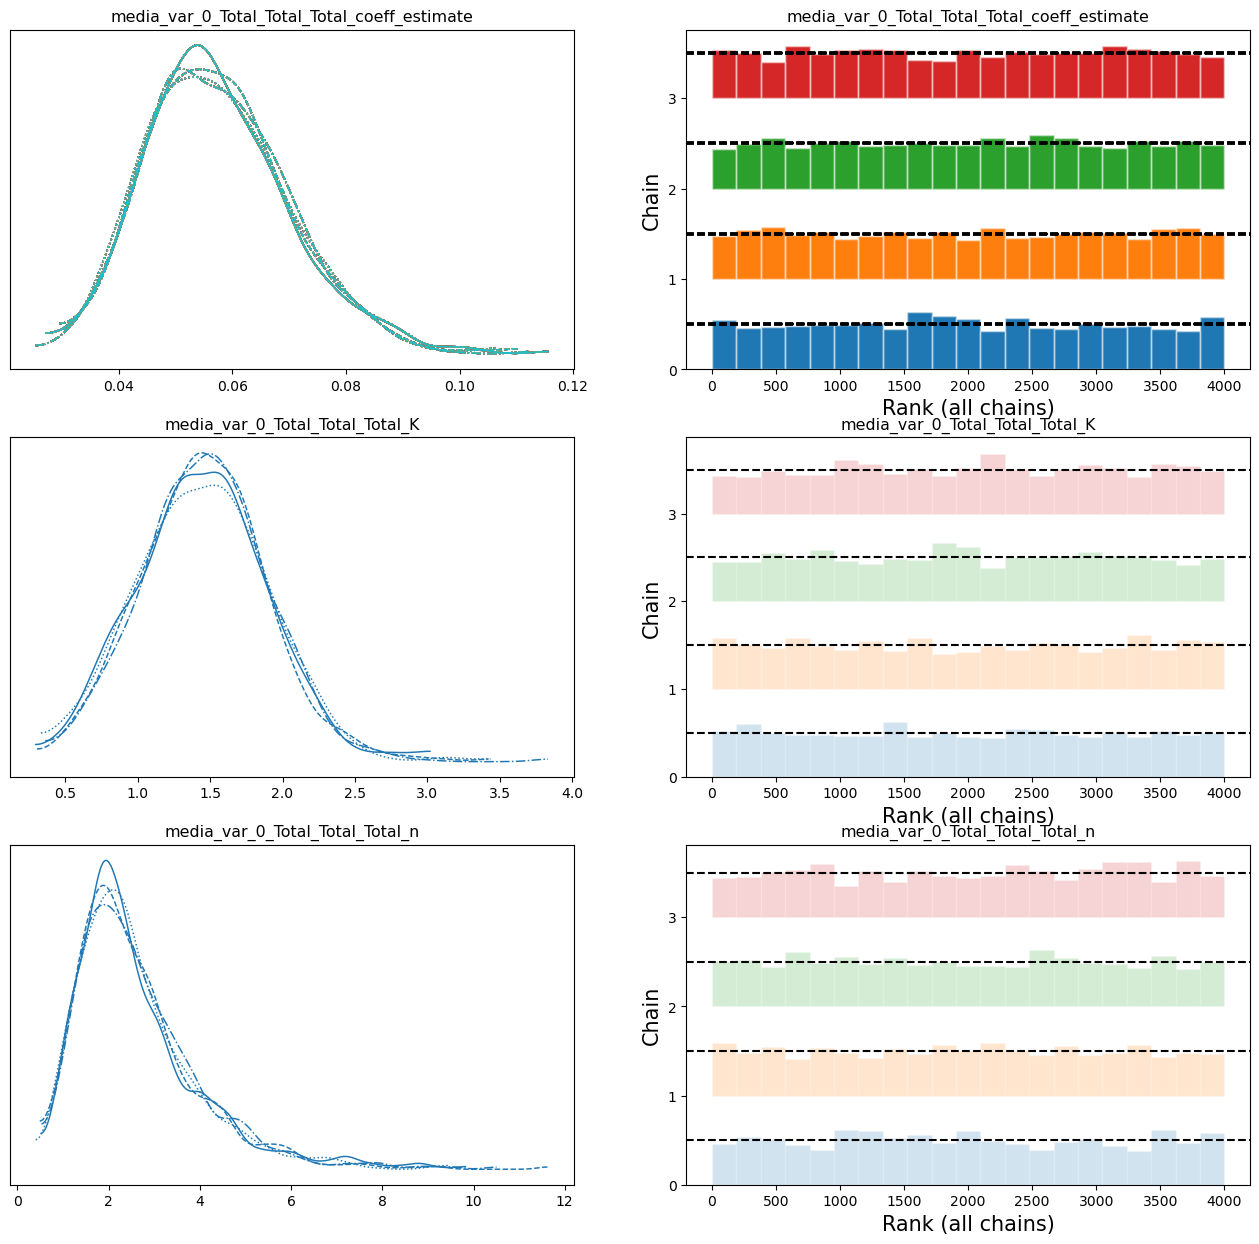

In [8]:
my_model.plot_posterior(varname=['Promotion_Total_Total_Total', "media_var_0_Total_Total_Total"]);
# The plots on the left define the distribution of the parameters, 
# while the plots on the right shows how well the sampler converged. 
# The bars should be close to each other

['Geography', 'Product', 'Period']
['Geography', 'Product', 'Period']


/Users/mreda/Downloads/FootTrafficModel/foottraffic/awb_model/models/model.py:219: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  posterior = pm.sample_posterior_predictive(self.trace)
Sampling: [Stock_Total_Total_Total_likelihood]


/Users/mreda/miniconda3/envs/foottraffic/lib/python3.11/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

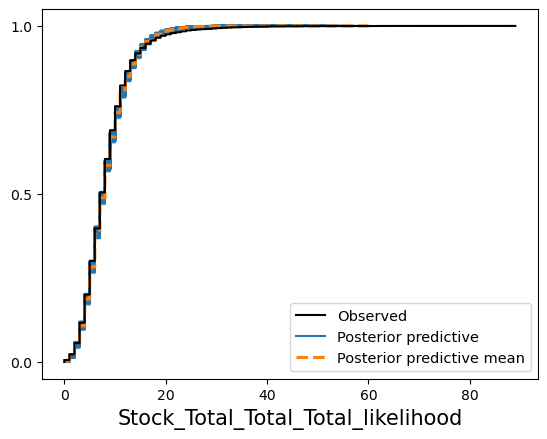

In [9]:
my_model.plot_posterior_predictive(); # This might take some time

In [10]:
avm = my_model.avm()
avm.head()

['Geography', 'Product', 'Period']
['Geography', 'Product', 'Period']


/Users/mreda/Downloads/FootTrafficModel/foottraffic/awb_model/models/model.py:218: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  with self.build():
Sampling: [Stock_Total_Total_Total_likelihood]


/Users/mreda/miniconda3/envs/foottraffic/lib/python3.11/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

,Geography,Product,Period,Stock_Total_Total_Total,Stock_Total_Total_Total_likelihood,mu
0,AU,Desktops,2020-04-06,14.0,10.68975,10.739228
1,AU,Desktops,2020-04-13,5.0,10.05300,9.994662
2,AU,Desktops,2020-04-20,5.0,5.37175,5.352427
3,AU,Desktops,2020-04-27,6.0,6.09050,6.144914
4,AU,Desktops,2020-05-04,10.0,8.21625,8.193867


In [14]:
contributions = my_model.get_contributions()
contributions.head()

,Geography,Product,Period,intercept_contribution,Promotion_Total_Total_Total_contribution,media_var_0_Total_Total_Total_contribution
0,AU,Desktops,2020-04-06,2.025823,0.344769,0.003008
1,AU,Desktops,2020-04-13,2.025823,0.240287,0.035786
2,AU,Desktops,2020-04-20,2.025823,-0.356107,0.007508
3,AU,Desktops,2020-04-27,2.025823,-0.214062,0.003735
4,AU,Desktops,2020-05-04,2.025823,0.070431,0.007107


## You can also directly examine the trace to further examine the posterior

In [15]:
my_model.trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

## Finally you can save the model

In [16]:
my_model.save("final_model")

/Users/mreda/miniconda3/envs/foottraffic/lib/python3.11/site-packages/pydantic/main.py:352: UserWarning: Pydantic serializer warnings:
  Expected `tuple[literal['Geography','Period','Product','Outlet','Campaign','Creative'], ...]` but got `list` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_json(
